# Wide and Deep Learning: Wine Price predictions

Are you able to predict the price of a certain wine bottle only from its description and region? Sincerely, I am not, but Machine learning can do it! 

In this exercise, we firstly use an ordinary/sequential Artificial Neural Network (ANNs) using Keras API and afterwards, a specific architecture of ANNs, called "Wide and Deep", to predict the wine price based on its regions and descriptions. 

                                              Marcus Duarte - 02/12/2020

                                              mvcduarte - at - gmail.com

In [1]:
# Importing some packages

import os
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(12345)

# Sklearn 

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

# Tensorflow

import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, concatenate

layers = keras.layers

print(keras.__version__)

%matplotlib inline

2.4.0


## 1 - The Wine Dataset  

In [2]:
# Import the dataset (randomize it and drop NaNs)

#!wget -q https://storage.googleapis.com/sara-cloud-ml/wine_data.csv
df = pd.read_csv("wine_data.csv").sample(frac = 1.).dropna()

df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
49024,49024,US,This barrel-fermented wine reflects the modest...,Reserve,88,28.0,Oregon,Dundee Hills,Willamette Valley,Chardonnay,Stoller
99700,99700,US,"So lush and soft, so delicious, you have to dr...",Thompson Vineyard,91,45.0,California,Santa Barbara County,Central Coast,Syrah,Ojai
31347,31347,US,"Tastes manipulated, with oak, honey and butter...",Mills Family Vineyard,84,20.0,California,Green Valley,Sonoma,Chardonnay,River Road
27042,27042,US,"What a great red wine, just about perfect for ...",Reserve,90,20.0,California,Alexander Valley,Sonoma,Malbec,Courtney Benham
149732,149733,US,"From the Sutter Home family, a super value. Yo...",Family Selection,87,12.0,California,California,California Other,Merlot,M. Trinchero


Note that the data is roughly based on words, being columns with descriptions, regions from, variety and winery. We will use all those fields/columns as input for ANNs and predict the wine price.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 49024 to 52593
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   39241 non-null  int64  
 1   country      39241 non-null  object 
 2   description  39241 non-null  object 
 3   designation  39241 non-null  object 
 4   points       39241 non-null  int64  
 5   price        39241 non-null  float64
 6   province     39241 non-null  object 
 7   region_1     39241 non-null  object 
 8   region_2     39241 non-null  object 
 9   variety      39241 non-null  object 
 10  winery       39241 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 3.6+ MB


The next step is to separate those fields in the DataFrame into two classes: 

- Geographic features

- Wine descriptions (general description, variety and winery).

Note that each information class has distinct information. The first one is based on **geographic information** and the second one represents the **wine features**, such as taste, visual aspect, grape, etc. Afterwards, we separate the initial sample into training, test and validation samples.  

In [4]:
# 1st option: Combine only GEOGRAPHIC FEATURES: province, region_1, region_2 (all wines are from US) 

df['geographic_designation'] = df[['province', 'region_1', 'region_2']].agg(' '.join, axis = 1)

# 2nd option: Combine only WINE FEATURES (wine tasting, smells, etc): description + variety + winery 

df['desc_designation'] = df[['description', 'variety', 'winery']].agg(' '.join, axis = 1)

# Divide the sample into Train, Test and Validation samples 

df_train, df_test, df_validation = np.split(df, [int(.7 * df.shape[0]), int(.85 * df.shape[0])])

Once the Dataframe was split into training, test and validation sample, it is necessary to transform words into numbers since ANNs do not accept directly text as input (not for this example). To do so, we use the Tokenizer function from Keras, which counts words from each document, i.e., the bag-of-words technique. At the end of the day, we have a matrix of 0s and 1, 2,.. representing each description (geographic designation or desc designation) a row and each word a respective column.  

In [5]:
# Tokenize its designation 

tokenize = keras.preprocessing.text.Tokenizer(char_level = False)
tokenize.fit_on_texts(df['geographic_designation'].values)

# Train, Test and Validation 

X_train = tokenize.texts_to_matrix(df_train['geographic_designation'].values)
y_train = df_train['price'].values
X_test = tokenize.texts_to_matrix(df_test['geographic_designation'].values)
y_test = df_test['price'].values
X_validation = tokenize.texts_to_matrix(df_validation['geographic_designation'].values)
y_validation = df_validation['price'].values

# Get list of words 

list_words = list(tokenize.word_index.keys())
print('list_words=', list_words)
print(len(list_words))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_validation.shape, y_validation.shape)

list_words= ['california', 'valley', 'sonoma', 'coast', 'central', 'napa', 'columbia', 'washington', 'oregon', 'willamette', 'wa', 'santa', 'county', 'river', 'russian', 'other', 'paso', 'robles', 'mendocino', 'hills', 'lake', 'lakes', 'finger', 'york', 'new', 'walla', 'counties', 'sierra', 'foothills', 'creek', 'dry', 'long', 'island', 'mountain', 'carneros', 'north', 'barbara', 'highlands', 'sta', 'rita', 'lucia', 'yakima', 'alexander', 'maria', 'mountains', 'ynez', 'red', 'lodi', 'monterey', 'anderson', 'of', 'district', 'edna', 'horse', 'heaven', 'fork', 'cruz', 'southern', 'dundee', 'arroyo', 'livermore', 'rutherford', 'amador', 'wahluke', 'slope', 'oakville', 'chehalem', 'el', 'dorado', 'san', 'green', 'eola', 'amity', 'grande', 'or', 'shenandoah', 'ca', 'seco', 'south', 'st', 'helena', 'howell', 'ridge', 'mount', 'veeder', 'diamond', 'knights', 'stags', 'leap', 'rogue', 'yamhill', 'luis', 'obispo', 'oak', 'knoll', 'carlton', 'temecula', 'harlan', 'umpqua', 'mt', 'chalk', 'hill',

It is important to mention that we have 209 features as input. Hey, it is a 
lot of features, right!? However, it is still feasible for an ordinary CPU.

## 2 - Define an ANN model 

Let's define an ANN model! For this example, we define an ANN with 1 hidden layer and a ReLU activation function (https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), as define by the Python routine below. Note that the number of neurons and the learning rate (https://en.wikipedia.org/wiki/Learning_rate) are input of the ann_model function.

In [6]:
# Define a ANN model 

def ann_model(n_col_input, n_neurons, lr):

    # Neural Network Architecture

    ann_inputs = layers.Input(shape = (n_col_input,))
    hidden1 = layers.Dense(n_neurons)(ann_inputs)
    embed_out = layers.Dense(1, activation = 'relu')(hidden1)
    ann_model = keras.Model(inputs = ann_inputs, outputs = embed_out)

    # Compile it 

    optimizer = Adam(lr = lr)
    ann_model.compile(loss = 'mse', optimizer = optimizer)

    return ann_model

Keras allows us to generate a graph of the ANN using the plot_model function.


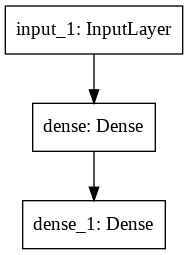

In [7]:
tf.keras.utils.plot_model(ann_model(X_train.shape[0], 30, 0.0001), to_file = 'model.png')

## 3 - Train an Artificial Neural Network

Once the text is pre-processed and the architecture of the ANN is defined, we can now train our ANN. Remember that the learning rate is one of the most important parameter of a ANN, so we will train our model and compare the performance of the trained models as a function of the learning rate. Thus, the learning rate varies from $10^{-5}$ to $10^{-3}$ and having 100 epochs. We will use a hidden layer of 128 neurons. 

lr_array= [1.e-05 1.e-04 1.e-03 1.e-02]
n_epoch= 100
Epoch 1/100
215/215 [==============================] - 1s 2ms/step - loss: 2165.0698 - val_loss: 2076.5759
Epoch 2/100
215/215 [==============================] - 0s 2ms/step - loss: 2154.0146 - val_loss: 2063.6418
Epoch 3/100
215/215 [==============================] - 0s 2ms/step - loss: 2139.9241 - val_loss: 2049.2820
Epoch 4/100
215/215 [==============================] - 0s 2ms/step - loss: 2125.8918 - val_loss: 2035.4303
Epoch 5/100
215/215 [==============================] - 0s 2ms/step - loss: 2111.9504 - val_loss: 2021.3024
Epoch 6/100
215/215 [==============================] - 0s 2ms/step - loss: 2097.7625 - val_loss: 2007.0272
Epoch 7/100
215/215 [==============================] - 0s 2ms/step - loss: 2083.3789 - val_loss: 1992.4834
Epoch 8/100
215/215 [==============================] - 0s 2ms/step - loss: 2068.7041 - val_loss: 1977.6266
Epoch 9/100
215/215 [==============================] - 0s 2ms/step - loss: 2053.6997 - val_

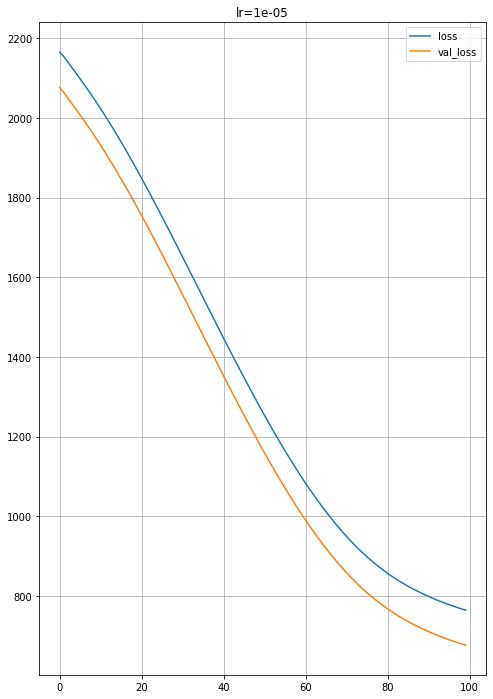

*******************************************************************
Epoch 1/100
215/215 [==============================] - 2s 7ms/step - loss: 2103.8857 - val_loss: 1944.1584
Epoch 2/100
215/215 [==============================] - 0s 2ms/step - loss: 1936.1848 - val_loss: 1751.1769
Epoch 3/100
215/215 [==============================] - 0s 2ms/step - loss: 1722.1523 - val_loss: 1519.3037
Epoch 4/100
215/215 [==============================] - 0s 2ms/step - loss: 1484.6233 - val_loss: 1281.3647
Epoch 5/100
215/215 [==============================] - 0s 2ms/step - loss: 1259.1180 - val_loss: 1072.2548
Epoch 6/100
215/215 [==============================] - 0s 2ms/step - loss: 1074.0385 - val_loss: 912.9831
Epoch 7/100
215/215 [==============================] - 0s 2ms/step - loss: 941.3497 - val_loss: 805.8021
Epoch 8/100
215/215 [==============================] - 0s 2ms/step - loss: 856.4388 - val_loss: 739.5597
Epoch 9/100
215/215 [==============================] - 0s 2ms/step - loss: 804.40

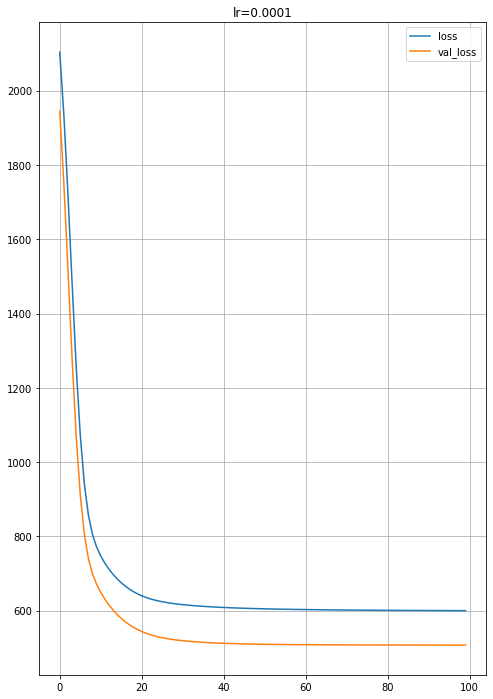

*******************************************************************
Epoch 1/100
215/215 [==============================] - 1s 3ms/step - loss: 1335.0768 - val_loss: 670.7733
Epoch 2/100
215/215 [==============================] - 1s 2ms/step - loss: 691.4056 - val_loss: 557.3740
Epoch 3/100
215/215 [==============================] - 0s 2ms/step - loss: 632.4729 - val_loss: 525.5812
Epoch 4/100
215/215 [==============================] - 0s 2ms/step - loss: 615.8516 - val_loss: 515.6794
Epoch 5/100
215/215 [==============================] - 0s 2ms/step - loss: 609.6282 - val_loss: 511.7065
Epoch 6/100
215/215 [==============================] - 0s 2ms/step - loss: 606.5038 - val_loss: 510.3893
Epoch 7/100
215/215 [==============================] - 0s 2ms/step - loss: 604.2917 - val_loss: 508.9222
Epoch 8/100
215/215 [==============================] - 0s 2ms/step - loss: 603.2567 - val_loss: 508.7738
Epoch 9/100
215/215 [==============================] - 0s 2ms/step - loss: 602.4717 - val_l

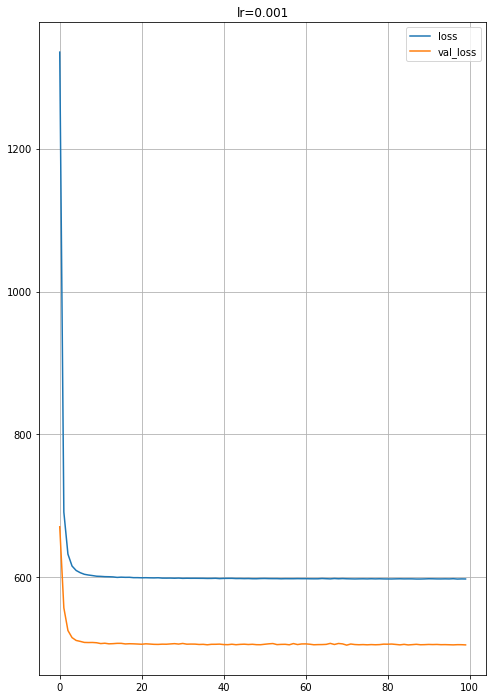

*******************************************************************
Epoch 1/100
215/215 [==============================] - 1s 2ms/step - loss: 719.7133 - val_loss: 514.9879
Epoch 2/100
215/215 [==============================] - 0s 2ms/step - loss: 609.5339 - val_loss: 508.6491
Epoch 3/100
215/215 [==============================] - 0s 2ms/step - loss: 607.7635 - val_loss: 509.1467
Epoch 4/100
215/215 [==============================] - 0s 2ms/step - loss: 606.8552 - val_loss: 511.2661
Epoch 5/100
215/215 [==============================] - 0s 2ms/step - loss: 605.8096 - val_loss: 508.8336
Epoch 6/100
215/215 [==============================] - 0s 2ms/step - loss: 606.5169 - val_loss: 508.1758
Epoch 7/100
215/215 [==============================] - 0s 2ms/step - loss: 604.3885 - val_loss: 509.4962
Epoch 8/100
215/215 [==============================] - 0s 2ms/step - loss: 603.6818 - val_loss: 514.9658
Epoch 9/100
215/215 [==============================] - 0s 2ms/step - loss: 604.3893 - val_lo

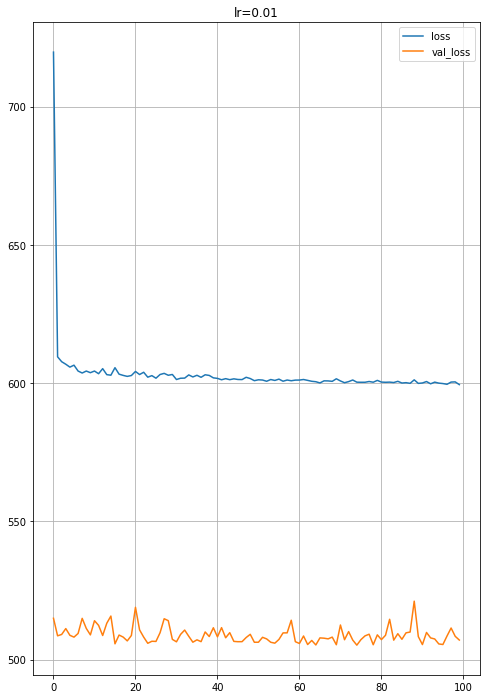

*******************************************************************
mse_lr_array= [535.4659926987061, 403.9926725346157, 401.55594271904704, 401.0883680801634]


In [8]:
lr_array = 10**np.array([-5., -4., -3., -2.])
n_epoch = 100
print('lr_array=', lr_array)
print('n_epoch=', n_epoch)

mse_lr_array = []
dic_y_pred = {}
for i_lr, lr in enumerate(lr_array):

    # Create model 

    model_ann = ann_model(X_train.shape[1], 128, lr)

    # Fit

    history = model_ann.fit(X_train, y_train, 
                            epochs = n_epoch,
                            validation_data = (X_validation, y_validation),
                            batch_size = 128)

    y_pred = model_ann.predict(X_test)
    dic_y_pred[i_lr] = y_pred

    # Calculate MSE 

    mse_lr_array.append(mean_squared_error(y_pred, y_test))

    print('MSE and ave(diff)=', mean_squared_error(y_pred, y_test), np.average(y_pred - y_test))

    # Plot it 

    pd.DataFrame(history.history).plot(figsize=(8, 12))
    plt.title('lr=' + str(lr))
    plt.grid()
    plt.show()
    #plt.savefig('loss_lr' + str(lr) + '.png')
    print('*******************************************************************')

print('mse_lr_array=', mse_lr_array)


Next, we plot the MSE as a function of the learning rate. It is important to mention that the best learning rate is between $10^{ -4}$ and $10^{-3}$. 

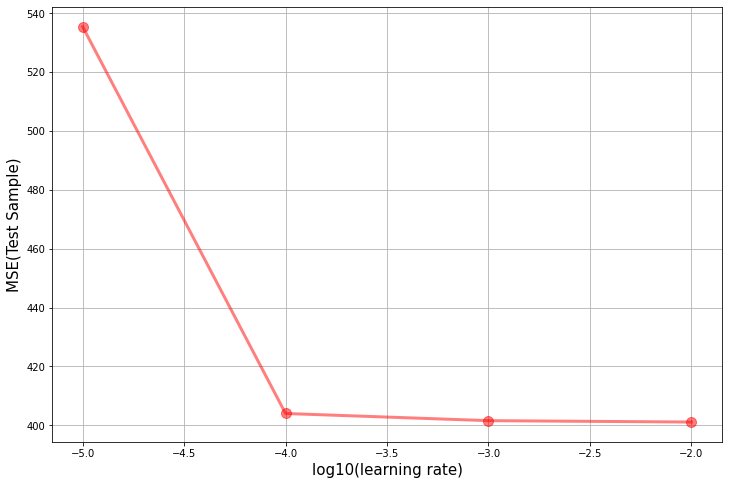

In [9]:
fig = plt.figure(figsize = (12, 8))
plt.plot(np.log10(lr_array), mse_lr_array, '-o', markersize = 10, lw = 3, color = 'red', alpha = 0.5)
plt.ylabel('MSE(Test Sample)', fontsize = 15)
plt.xlabel('log10(learning rate)', fontsize = 15)
plt.grid()

How about if we include the desc_designation as features, in the same way we did with geographic ones?

In [10]:
# Create a tokenizer to pre-process our "desc_designation" field

tokenize_desc = keras.preprocessing.text.Tokenizer(char_level = False)
tokenize_desc.fit_on_texts(df_train['desc_designation'].values)

desc_train = tokenize_desc.texts_to_matrix(df_train['desc_designation'].values)
desc_test = tokenize_desc.texts_to_matrix(df_test['desc_designation'].values)
desc_validation = tokenize_desc.texts_to_matrix(df_validation['desc_designation'].values)

list_words_desc = list(tokenize_desc.word_index.keys())
print('list_words_desc=', list_words_desc[:10])
print(desc_train.shape, X_train.shape)

list_words_desc= ['and', 'the', 'a', 'of', 'with', 'this', 'in', 'is', 'flavors', 'wine']
(27468, 17960) (27468, 209)


WOW! It is a matrix with $\sim$17k columns, then we need a sequential ANN much larger than that we have now! How do we process all this additional data?
One approach is the Wide and Deep Learning! :)

# 4 - Wide & Deep Learning

Wide and Deep learning is a certain configuration/architecture of neural networks that combines linear models (generalization and memorization) and deep learning (detailed characteristics) in one model. One can train a wide linear model in parallel with a deep neural network at once. it can be quite useful for large number of features as inputs for regression and classification systems, such as recommender systems.

In [11]:
# Wide Model

wide = Input(shape = (desc_train.shape[1],))

# Deep Model

n_col_input = X_train.shape[1]
deep_data = Input(shape = (n_col_input,))
deep1 = Dense(128, activation = 'relu')(deep_data)
deep = Dense(1)(deep1)

# Wide & Deep

wide_deep = concatenate([wide, deep])
wide_deep_out = Dense(1, activation = 'relu')(wide_deep)
model = Model(inputs = [wide, deep_data], outputs = wide_deep_out)

The architecture of the Wide and Deep Neural Network is represented below. The desc_designation (more than 17k features) enters in the model in the last layer before the output layer. It means that it will not pass throurgh the ANN model, saving a lot of computational time.  

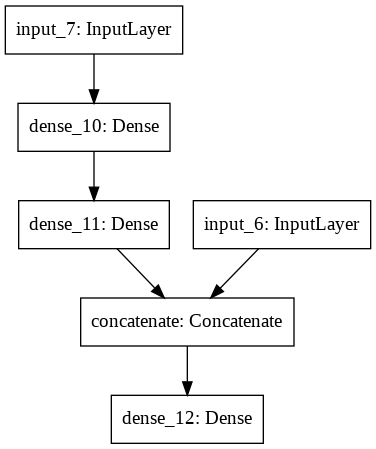

In [12]:
tf.keras.utils.plot_model(model, to_file = 'model_wide_deep.png')

lr= 0.0001
n_epoch= 700
Epoch 1/700
859/859 [==============================] - 4s 5ms/step - loss: 2048.6113 - val_loss: 1790.0127
Epoch 2/700
859/859 [==============================] - 4s 5ms/step - loss: 1583.7042 - val_loss: 1180.6586
Epoch 3/700
859/859 [==============================] - 4s 5ms/step - loss: 1010.3472 - val_loss: 741.8820
Epoch 4/700
859/859 [==============================] - 4s 4ms/step - loss: 765.3226 - val_loss: 639.5439
Epoch 5/700
859/859 [==============================] - 4s 5ms/step - loss: 710.3813 - val_loss: 603.3305
Epoch 6/700
859/859 [==============================] - 4s 5ms/step - loss: 680.0284 - val_loss: 574.4514
Epoch 7/700
859/859 [==============================] - 4s 4ms/step - loss: 654.9108 - val_loss: 550.2169
Epoch 8/700
859/859 [==============================] - 4s 4ms/step - loss: 633.8828 - val_loss: 529.7343
Epoch 9/700
859/859 [==============================] - 4s 4ms/step - loss: 616.2567 - val_loss: 512.2676
Epoch 10/700
859/859 [====

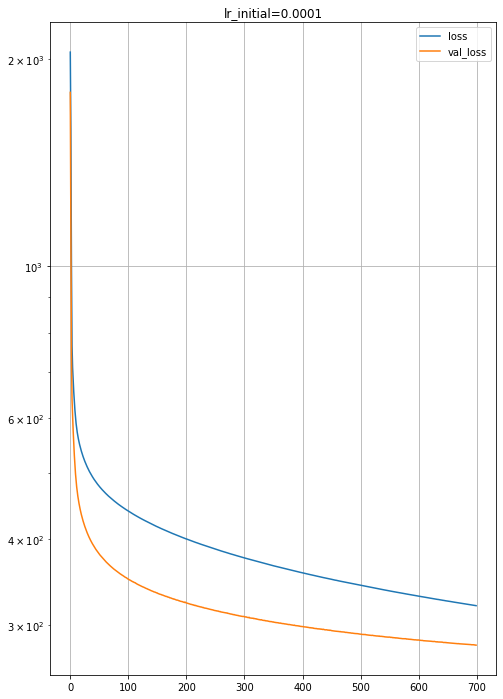

In [13]:

lr_initial = 0.0001 # learning rate
n_epoch = 700       # number of epochs
print('lr=', lr_initial)
print('n_epoch=', n_epoch)

# Compile the Keras model API 

optimizer = Adam(learning_rate = lr_initial)
model.compile(optimizer = optimizer, loss = 'mse')

# Fit 

history = model.fit([desc_train, X_train], y_train, 
                    validation_data = ([desc_validation, X_validation], y_validation),
                    epochs = n_epoch, verbose = 1)

print('MSE(test)=', model.evaluate([desc_test, X_test], y_test))

# Plot it 

pd.DataFrame(history.history).plot(figsize=(8, 12), logy = True)
plt.title('lr_initial=' + str(lr_initial))
plt.grid()
plt.show()

In [14]:
y_pred = model.predict([desc_test, X_test])
print('MSE(Test)(Wide and Deep)=', mean_squared_error(y_pred, y_test))
print('MSE(Test)(ANN)=', mean_squared_error(dic_y_pred[1], y_test)) # using ANN and lr = 1e-4 (see previous section) 

MSE(Test)(Wide and Deep)= 212.3361372372731
MSE(Test)(ANN)= 403.9926725346157


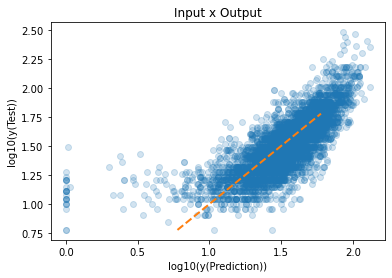

In [15]:
plt.plot(np.log10(y_pred + 1.), np.log10(y_test + 1.), 'o', alpha = 0.2)
x = np.arange(min(np.log10(y_test + 1.)), max(np.log10(y_test + 1.)))
plt.plot(x, x, '--', lw = 2.)
plt.ylabel('log10(y(Test))')
plt.xlabel('log10(y(Prediction))')
plt.title('Input x Output')
plt.show()

## Conclusions

A Artificial Neural Network is an interesting model to predict the wine price for the chosen dataset. However, if one decides to include more information, besides the geographic one, the ANN model can be quite slow due to the huge number of input features and your computational time explodes. One alternative to circumvent this problem is to use Wide and Deep models, which is able to memorize (linear model) and generalizations (deep models) and at the same time. Comparing the performance of both models, we can notice that the MSE for ANN and Wide and Deep (WD) model are $\sim$400 and $\sim$210, respectively. It indicates that the WD can include more information (a bunch of features) as input and consequently improves the performance, and at the same time roughly keeps the computational time.    

## Improvements

- The validation loss is below the training loss. It can indicates that those samples are not restrictly representative of each other. 

- Some training and validation loss curves are quite noisy, maybe we need to pay a bit with the architecture or parameters of both models. 

- Include the column "winery" in the bag-of-words and check if the model performance really improves. 

- Use the TF-IDF (https://en.wikipedia.org/wiki/Tf%E2%80%93idf) instead of bag-of-words and check the performance. 

- Remove "stop words" to discard unnecessary features. 
